**Import Libraries**

In [2]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

**Import Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [4]:
datasetdir = '/content/drive/MyDrive/Bird'
os.chdir(datasetdir)


In [5]:
# Load file locations
df_info = pd.read_excel('dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('dataset_information.xlsx', sheet_name = 'classes.txt')

#Read Train Test Split details
df_train_test = pd.read_csv('train_test_split.csv')

In [6]:
df_classes.head(10)

,child_class_id,class_description
0,1,"Ducks, Geese, and Swans"
1,2,"Grouse, Quail, and Allies"
2,3,Loons
3,4,Grebes
4,5,Storks
5,6,"Frigatebirds, Boobies, Cormorants, Darters, an..."
6,7,"Pelicans, Herons, Ibises, and Allies"
7,8,"Hawks, Kites, Eagles, and Allies"
8,9,Caracaras and Falcons
9,10,Cranes and Rails


In [7]:
#Split the class and imange name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [8]:
df_image.tail(10)

,image_id,image_location,class_id,image_name
48552,ffef2e23-edd7-4221-88a8-074ac0773d77,0786/ffef2e23edd7422188a8074ac0773d77.jpg,0786,ffef2e23edd7422188a8074ac0773d77.jpg
48553,ffef9325-d321-4129-825d-2d7dddeeb824,0980/ffef9325d3214129825d2d7dddeeb824.jpg,0980,ffef9325d3214129825d2d7dddeeb824.jpg
48554,fff0b2c3-5ab3-4c64-b160-a77398fe5a46,0527/fff0b2c35ab34c64b160a77398fe5a46.jpg,0527,fff0b2c35ab34c64b160a77398fe5a46.jpg
48555,fff1d97b-2ac3-410d-8c6d-7430470bb951,0503/fff1d97b2ac3410d8c6d7430470bb951.jpg,0503,fff1d97b2ac3410d8c6d7430470bb951.jpg
48556,fff3ec39-07d4-4600-b753-12013066277f,0999/fff3ec3907d44600b75312013066277f.jpg,0999,fff3ec3907d44600b75312013066277f.jpg
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,0891/fff86e8b795f400a91e8565bbb8c453a.jpg,0891,fff86e8b795f400a91e8565bbb8c453a.jpg
48558,fff926d7-ccad-4788-839e-97af2dd99372,0660/fff926d7ccad4788839e97af2dd99372.jpg,0660,fff926d7ccad4788839e97af2dd99372.jpg
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,0492/fffa33efa765408d8d666efc7f504c71.jpg,0492,fffa33efa765408d8d666efc7f504c71.jpg
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,0372/ffff0d87bc844ef2a47ea4bfa48502ce.jpg,0372,ffff0d87bc844ef2a47ea4bfa48502ce.jpg
48561,fffff3a5-2a75-47d0-887f-03871e3f9a37,0880/fffff3a52a7547d0887f03871e3f9a37.jpg,0880,fffff3a52a7547d0887f03871e3f9a37.jpg


In [9]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [10]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [11]:
df_bird.head(10)

,image_id,image_location,class_id,image_name,class_description
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,817,0000139e21dc4d0cbfe14cae3c85c829.jpg,Oak Titmouse
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,860,0000d9fc4e024c06a0afa55cfb16b12b.jpg,Ovenbird
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,900,000193069d834334b255a447742edce3.jpg,Savannah Sparrow
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,645,0001afd499a14a67b940d419413e23b3.jpg,Eared Grebe (Nonbreeding/juvenile)
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,929,000332b8997c454096472f0a8495aecf.jpg,Eastern Phoebe
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,0652/000343bd521549baab9c7c97a70ac1a5.jpg,652,000343bd521549baab9c7c97a70ac1a5.jpg,Yellow-crowned Night-Heron (Immature)
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,0951/0004ff8d0cc847ee94ba43352a8b9eb4.jpg,951,0004ff8d0cc847ee94ba43352a8b9eb4.jpg,Florida Scrub-Jay
7,0007181f-a727-4481-ad89-591200c61b9d,0900/0007181fa7274481ad89591200c61b9d.jpg,900,0007181fa7274481ad89591200c61b9d.jpg,Savannah Sparrow
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,0988/00071e2081564bd8b5ca6445c2560ee5.jpg,988,00071e2081564bd8b5ca6445c2560ee5.jpg,Yellow-headed Blackbird (Female/Immature Male)
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,0400/0007acfcc0e643939ab602215a82ef63.jpg,400,0007acfcc0e643939ab602215a82ef63.jpg,Herring Gull (Adult)


In [12]:
#Find the count of bird class in case only specific classes need to be to the model
df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

,class_id,count
523,979,120
446,902,120
275,672,120
80,397,120
400,856,120
...,...,...
550,1006,25
299,755,24
33,341,23
267,664,21


In [13]:
#Find the count of bird class in case only specific classes need to be to the model
df_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [15]:
#Selected only specific labels
target_class = df_classcounts[(df_classcounts['count']>=90) & (df_classcounts['count']<=120)]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [16]:
df_classcounts['count'].values

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117,
       117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112,
       111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 10

In [17]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]
df_target.shape

(31330, 6)

In [18]:
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

**Prepare Training and Validation Set**

In [19]:
df_train_test.head(10)

,image,train
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0
2,00019306-9d83-4334-b255-a447742edce3,0
3,0001afd4-99a1-4a67-b940-d419413e23b3,1
4,000332b8-997c-4540-9647-2f0a8495aecf,0
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,0
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,0
7,0007181f-a727-4481-ad89-591200c61b9d,1
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,1
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,0


In [20]:
#Join the target and train test dataframe 
df_target = pd.merge(df_target, df_train_test, left_on='image_id', right_on='image', how='left').drop('image', axis=1)

**Train set**

In [21]:
df_train =  df_target[df_target['train']==1]
df_train.shape

(15507, 7)

In [22]:
X_train = df_train['image_location']
y_train = df_train['class_id']

**Validation and Test set**

In [23]:
df_valtest =  df_target[df_target['train']==0]
df_valtest.shape

(15823, 7)

In [24]:
X_val, X_test, y_val, y_test = train_test_split(df_valtest['image_location'], df_valtest['class_id'], test_size=0.25, random_state=44)
TotalImages = len(X_train) + len(X_val) + len(X_test)
print("Number of images for training: ", len(X_train))
print("Number of images for validation: ", len(X_val))
print("Number of images for testing: ", len(X_test))
print("Total Images in Train Test Val Set is: ",TotalImages )

Number of images for training:  15507
Number of images for validation:  11867
Number of images for testing:  3956
Total Images in Train Test Val Set is:  31330


**Add directory path**

In [25]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
X_test = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_test]

X_train[:3]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0900/0007181fa7274481ad89591200c61b9d.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0651/000948ee8c1940bb840372c665e7ffc3.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0947/000c3c44dd8c4efe949e3adfd766d719.jpg']

**Show sample image**

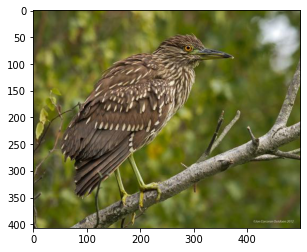

In [26]:
plt.imshow(Image.open(X_train[1]))

**Encode the Target Labels**

In [27]:
y_train.shape

(15507,)

In [28]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [29]:
lb.classes_

array(['1001', '1002', '1003', '299', '314', '315', '316', '317', '319',
       '320', '322', '328', '332', '333', '335', '338', '340', '343',
       '347', '348', '350', '351', '352', '353', '354', '355', '356',
       '357', '358', '363', '366', '368', '371', '373', '374', '375',
       '379', '380', '381', '382', '395', '397', '400', '446', '448',
       '450', '451', '453', '458', '469', '470', '473', '477', '480',
       '481', '482', '483', '484', '485', '486', '489', '490', '491',
       '495', '498', '499', '501', '503', '504', '508', '509', '510',
       '511', '512', '513', '514', '515', '516', '519', '520', '521',
       '522', '523', '525', '527', '528', '529', '530', '533', '536',
       '538', '539', '541', '542', '543', '544', '549', '550', '551',
       '553', '554', '555', '557', '558', '559', '560', '561', '607',
       '613', '616', '640', '642', '643', '647', '651', '654', '655',
       '656', '657', '662', '667', '668', '669', '672', '673', '674',
       '676', '68

In [30]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)
y_test_bin = lb.transform(y_test)
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((15507, 283), (11867, 283), (3956, 283))

**Define the Image Size for the model**

In [31]:
IMG_SIZE = 224 #Image size
CHANNELS = 3 # Keep RGB color channels 
N_CLASSES = len(lb.classes_) #Total no.of classes

**Map the filename and label to create Dataset**

In [32]:
def parse_img_label(filename, label):

    # Read an image from a file
    image_string = tf.io.read_file(filename)

    # Decode it into a  vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)

    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])

    # Normalize the image
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [33]:
BATCH_SIZE = 512 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 256

In [34]:
def gen_dataset(filenames, labels, is_training=True):

 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_img_label, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [35]:
train_ds = gen_dataset(X_train, y_train_bin)
val_ds = gen_dataset(X_val, y_val_bin)
test_ds = gen_dataset(X_test,y_test_bin)

In [36]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 283)


**Prepare Transfer Learning Model - HUB MobileNet V2 140_224**

In [37]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [38]:
feature_extractor_layer.trainable = False

In [39]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(4096, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(2048, activation='relu', name='hidden_layer2'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu', name='hidden_layer3'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer4'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              4363712   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 4096)              7344128   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

**Define MACRO F1 Score for multi-class**

In [41]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
     metrics=[macro_f1, 'accuracy'] )
    

In [43]:
batch_size = 256
history = model.fit(train_ds,batch_size=batch_size, epochs=50, validation_data=val_ds,validation_batch_size= batch_size)

Epoch 1/50
31/31 [==============================] - 227s 7s/step - loss: 0.2238 - macro_f1: 0.0020 - accuracy: 0.0043 - val_loss: 0.0269 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0036
Epoch 2/50
31/31 [==============================] - 131s 4s/step - loss: 0.0271 - macro_f1: 0.0000e+00 - accuracy: 0.0041 - val_loss: 0.0242 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0034
Epoch 3/50
31/31 [==============================] - 134s 4s/step - loss: 0.0248 - macro_f1: 0.0000e+00 - accuracy: 0.0053 - val_loss: 0.0235 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0174
Epoch 4/50
31/31 [==============================] - 131s 4s/step - loss: 0.0240 - macro_f1: 0.0000e+00 - accuracy: 0.0093 - val_loss: 0.0227 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0329
Epoch 5/50
31/31 [==============================] - 133s 4s/step - loss: 0.0230 - macro_f1: 0.0000e+00 - accuracy: 0.0198 - val_loss: 0.0210 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0640
Epoch 6/50
31/31 [==============================]

**Evaluate the Model**

In [44]:
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 34s 4s/step - loss: 0.0151 - macro_f1: 0.4143 - accuracy: 0.5561


{'accuracy': 0.5561172962188721,
 'loss': 0.015103967860341072,
 'macro_f1': 0.41426974534988403}

**Model Performance**

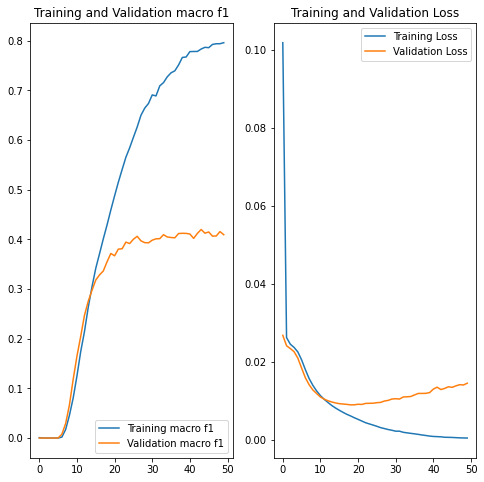

In [45]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [191]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/Bird/model_img104224') 

**Show Predicted Images**

In [192]:
 results = (model.predict(test_ds) > 0.5).astype('int')



Actual Class: 776

Actual Class_descriptions: Lazuli Bunting (Adult Male)

Predicted Class: 776


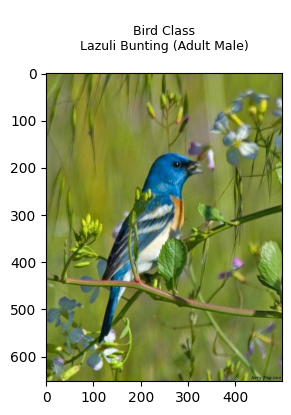


Actual Class: 539

Actual Class_descriptions: Great Horned Owl

Predicted Class: 539


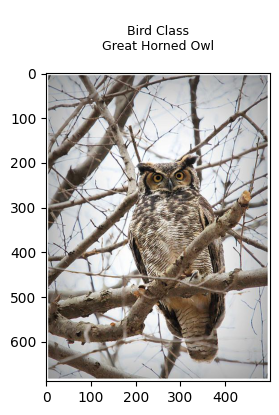


Actual Class: 769

Actual Class_descriptions: Chipping Sparrow (Breeding)

Predicted Class: 769


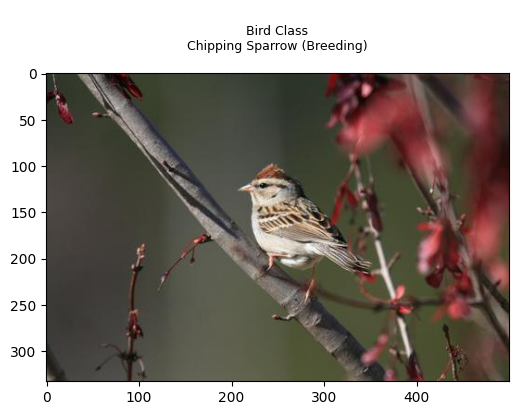


Actual Class: 382

Actual Class_descriptions: Northern Flicker (Yellow-shafted)

Predicted Class: 382


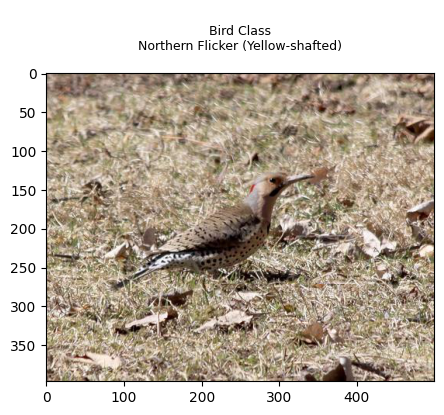


Actual Class: 613

Actual Class_descriptions: Wood Duck (Female/Eclipse male)

Predicted Class: 613


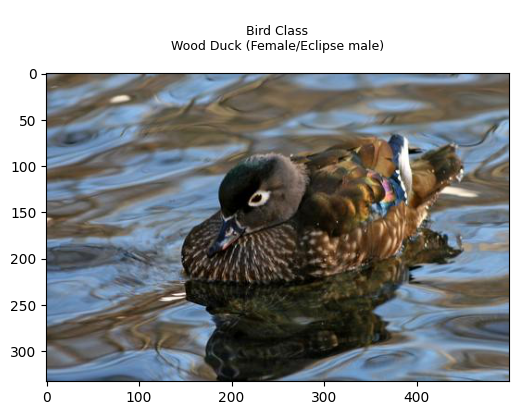


Actual Class: 862

Actual Class_descriptions: Northern Waterthrush

Predicted Class: 862


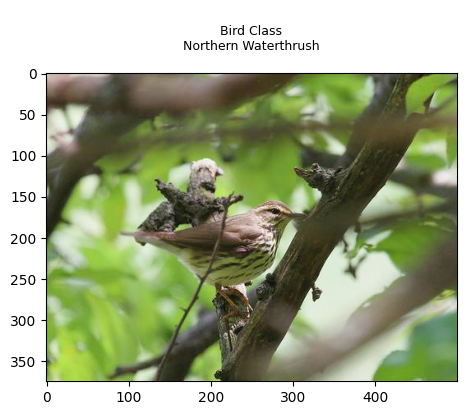


Actual Class: 912

Actual Class_descriptions: Common Grackle

Predicted Class: 912


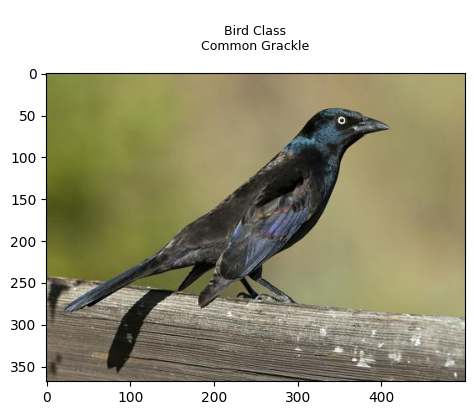


Actual Class: 777

Actual Class_descriptions: Indigo Bunting (Adult Male)

Predicted Class: 777


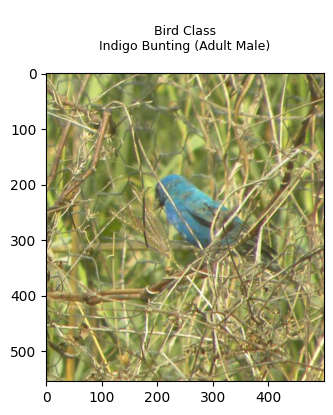


Actual Class: 781

Actual Class_descriptions: Yellow-headed Blackbird (Adult Male)

Predicted Class: 781


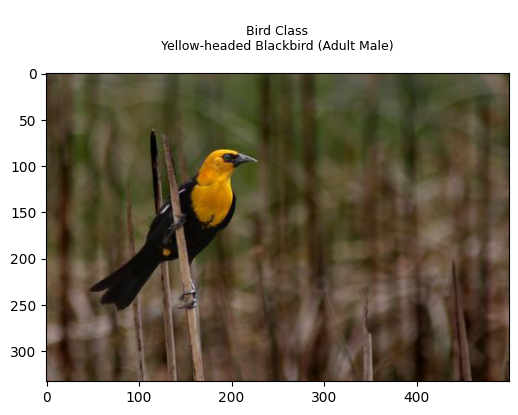


Actual Class: 450

Actual Class_descriptions: Common Tern

Predicted Class: 450


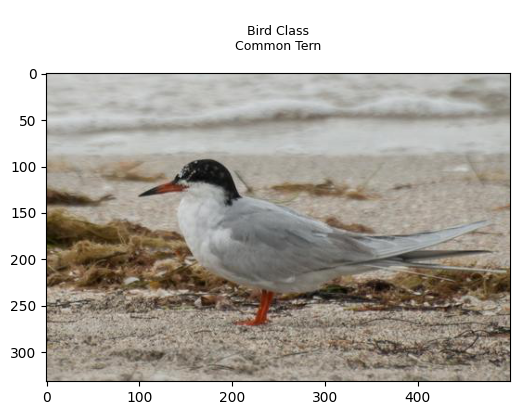

In [193]:
#Set the directory path to show images
dir_path ='/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/'

#Iterate through predictions to show correct predicted classes
for count in range(len(results[:3000])):
  pred = results[count]
  #print(pred)
  if np.max(pred) == 1:
    pred  = pd.Series(pred)
    pred.index = lb.classes_
    prediction = pred[pred==1].index.values
    pred_label = np.max(prediction)
    if str(pred_label) == df_target['class_id'][count]:
      print('\nActual Class:',df_target['class_id'][count])
      print('\nActual Class_descriptions:',df_target['class_description'][count])
      print('\nPredicted Class:',pred_label)
      
      img_path = dir_path + df_target['image_location'][count]
      style.use('default')
      plt.figure(figsize=(8,4))
      plt.imshow(Image.open(img_path))
      plt.title('\nBird Class\n{}\n'.format(df_target['class_description'][count]), fontsize=9)
      plt.show()
      #plt.imshow(Image.open(X_test[0]))
